# Machine Learning with Craft Beer



## Data, Wrangling, & EDA

In [6]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [7]:
breweries = pd.read_csv('breweries.csv')
beers = pd.read_csv('beers.csv')

In [8]:
breweries.head()

,Unnamed: 0,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


In [9]:
beers.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


To get a quick handle on what's going on these data, we're going to print out the number of missing values in each variable of the variables in the `beers` dataset .

In [10]:
beers.isna().sum()

Unnamed: 0       0
abv             62
ibu           1005
id               0
name             0
style            5
brewery_id       0
ounces           0
dtype: int64

We want to try to predict the `style` of beer from its alcohol by volume (`abv`) and its international bitterness unites (`ibu`). To do this, we need to remove any beers from our `beers` dataset where data are missing for any of these three values. 

In [11]:
beers = beers.dropna(subset=['style', 'abv', 'ibu'])

Using the `beers` dataset we are not going to merge `beers` and `breweries` together using a left join.

In [12]:
beer_df = pd.merge(beers, breweries, how='left')
beer_df

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces,city,state
0,14,0.061,60.0,1979,Bitter Bitch,American Pale Ale (APA),177,12.0,NaN,NaN
1,21,0.099,92.0,1036,Lower De Boom,American Barleywine,368,8.4,NaN,NaN
2,22,0.079,45.0,1024,Fireside Chat,Winter Warmer,368,12.0,NaN,NaN
3,24,0.044,42.0,876,Bitter American,American Pale Ale (APA),368,12.0,NaN,NaN
4,25,0.049,17.0,802,Hell or High Watermelon Wheat (2009),Fruit / Vegetable Beer,368,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1398,2398,0.077,30.0,1513,Lights Out Vanilla Cream Extra Stout,American Double / Imperial IPA,199,12.0,NaN,NaN
1399,2399,0.069,69.0,1512,Worthy IPA (2013),American IPA,199,12.0,NaN,NaN
1400,2400,0.060,50.0,1511,Worthy Pale,American Pale Ale (APA),199,12.0,NaN,NaN
1401,2405,0.067,45.0,928,Belgorado,Belgian IPA,424,12.0,NaN,NaN


In [13]:
beer_df.describe()

,Unnamed: 0,abv,ibu,id,brewery_id,ounces
count,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000
mean,1241.128297,0.059919,42.739843,1413.888810,223.375624,13.510264
std,691.675612,0.013585,25.962692,757.572191,150.387510,2.254112
min,14.000000,0.027000,4.000000,1.000000,0.000000,8.400000
25%,681.500000,0.050000,21.000000,771.000000,95.500000,12.000000
50%,1228.000000,0.057000,35.000000,1435.000000,198.000000,12.000000
75%,1864.500000,0.068000,64.000000,2068.500000,350.000000,16.000000
max,2408.000000,0.125000,138.000000,2692.000000,546.000000,32.000000


Now we're going to see how many different styles of beer we have in our datset.

In [14]:
beer_df['style'].value_counts()

American IPA                          301
American Pale Ale (APA)               153
American Amber / Red Ale               77
American Double / Imperial IPA         75
American Blonde Ale                    61
                                     ... 
Quadrupel (Quad)                        1
Flanders Oud Bruin                      1
Grisette                                1
Belgian Strong Dark Ale                 1
American Double / Imperial Pilsner      1
Name: style, Length: 90, dtype: int64

Due to the variety of beers, it'll be more simplistic to predict the four most common `style`s of beer. So we're going to filter the 4 most common beers and remove the rest from the data set.

In [15]:
beer_df = beer_df.loc[beer_df['style'].isin(['American IPA', 'American Pale Ale (APA)', 'American Amber / Red Ale', 'American Double / Imperial IPA'])]

## Prediction Model

Now we're going to begin to build our prediction model. To do so, we are going to make variable `num_training` that includes the number of samples that corresponds to 80% of our total samples in our `beer_df` dataset. Also, we are going to create a variable `num_testing` which includes the number corresponding to 20% of our total samples.

In [16]:
num_training = int(len(beer_df)*0.8)
num_testing = len(beer_df) - num_training

To model these data, we'll split our data into `beer_X`, which includes the `abv` and `ibu` columns from `beer_df` (predictors). Additionally we'll have the outcome variable stored in the variable `beer_Y`.

In [17]:
beer_X = beer_df[['abv', 'ibu']]
beer_Y = np.array(beer_df['style'])

Before running our model, we'll need to split our data into a training and test set.

In [18]:
beer_train_X = beer_X[:num_training]
beer_test_X = beer_X[num_training:]
beer_train_Y = beer_Y[:num_training]
beer_test_Y = beer_Y[num_training:]

To train our model, we'll use a linear SVM classifier.

In [19]:
def train_SVM(X, y, kernel='linear'):
    clf = SVC(kernel=kernel)
    clf.fit(X, y)
    
    return clf

We're going to now train our model and store it in the `beer_clf` variable

In [20]:
beer_clf = train_SVM(beer_train_X, beer_train_Y)

Now, we'll generate predictions from our training and test sets of predictors using the `predict` method.

In [21]:
beer_predicted_train_Y = beer_clf.predict(beer_train_X)
beer_predicted_test_Y = beer_clf.predict(beer_test_X)

## Model Assessment

Now we're going to determine how our predictor did. To do this we'll generate a `classification_report` for the predictions generated from oour training data relative to the truth (from the original beers dataset).

In [22]:
print(classification_report(beer_train_Y, beer_predicted_train_Y))

                                precision    recall  f1-score   support

      American Amber / Red Ale       0.82      0.45      0.58        69
American Double / Imperial IPA       0.76      0.25      0.37        53
                  American IPA       0.69      0.84      0.76       236
       American Pale Ale (APA)       0.57      0.64      0.60       126

                      accuracy                           0.67       484
                     macro avg       0.71      0.54      0.58       484
                  weighted avg       0.69      0.67      0.65       484



Now we'll generate a `classification_report` for the predictions generated for our test data relative to the truth (from the original beers dataset).

In [23]:
print(classification_report(beer_test_Y, beer_predicted_test_Y))

                                precision    recall  f1-score   support

      American Amber / Red Ale       0.62      0.62      0.62         8
American Double / Imperial IPA       0.78      0.32      0.45        22
                  American IPA       0.70      0.72      0.71        65
       American Pale Ale (APA)       0.55      0.78      0.65        27

                      accuracy                           0.66       122
                     macro avg       0.66      0.61      0.61       122
                  weighted avg       0.68      0.66      0.64       122



How is our model performing? Does this dffer between training and test data? Where does it have trouble? Where does it perform well? Do we have thoughts as to why? One way to determine where a model is going wrong is to look at a confusion matrix. What we'll do now is generate a confusion matrix for the training data predictions as well as the ground truth from the `beer_df` dataset.

In [28]:
conf_train = confusion_matrix(beer_train_Y, beer_predicted_train_Y)
conf_train

array([[ 31,   1,  10,  27],
       [  0,  13,  40,   0],
       [  0,   3, 198,  35],
       [  7,   0,  38,  81]])

In [29]:
conf_test = confusion_matrix(beer_test_Y, beer_predicted_test_Y)
conf_test

array([[ 5,  0,  2,  1],
       [ 1,  7, 14,  0],
       [ 0,  2, 47, 16],
       [ 2,  0,  4, 21]])

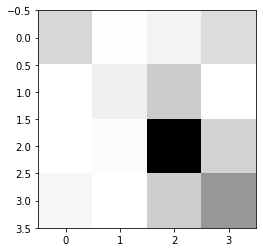

In [26]:
plt.imshow(conf_train, cmap='binary', interpolation='None')
plt.show()

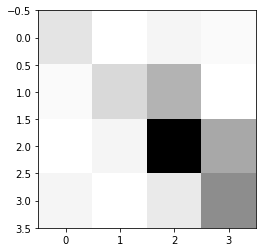

In [27]:
plt.imshow(conf_test, cmap='binary', interpolation='None')
plt.show()

We can see that our model didn't do too bad. As we can see there is a decent volume of correct predictions(values along the diagnol represent correct predictions). A better prediction model might be to use a decision tree since our data is slightly categorical(depending on how you view it). Overall, the model is pretty good for what was provided in the sample data.